In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [8]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [9]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [10]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station



In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Precipitation Analysis

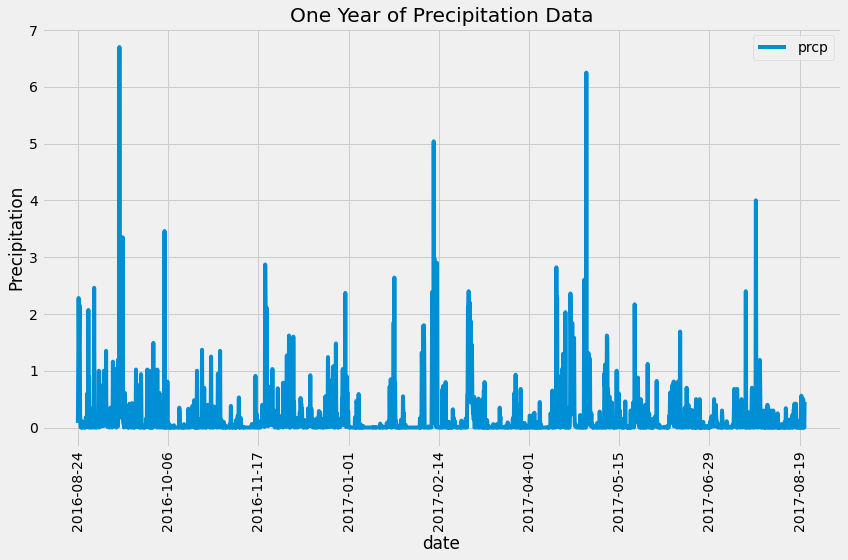

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date = session.query(measurement.date).order_by(measurement.date.desc()).first()
yearprior = dt.datetime.strptime(date[0], '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
scores = session.query(measurement.prcp, measurement.date) \
    .filter(measurement.date >= yearprior).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
scores_df = pd.DataFrame(scores, columns=['prcp', 'date']).set_index('date').dropna()

# Sort the dataframe by date
scores_df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
scores_df.plot(rot=90, figsize=(12,8), ylabel="Precipitation", title="One Year of Precipitation Data")
plt.tight_layout()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
scores_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

'2017-08-23'

# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(station.station)).first()[0]

9

In [17]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_counts = session.query(measurement.station, func.count(measurement.station)) \
    .group_by(measurement.station) \
    .order_by(func.count(measurement.station).desc()) \
    .all()
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
max_station = station_counts[0][0]

temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)) \
    .filter(measurement.station == max_station).first()

print(f"The lowest observed temperature for {max_station} was {temps[0]}, the highest was {temps[1]}, and the average was {temps[2]}")

The lowest observed temperature for USC00519281 was 54.0, the highest was 85.0, and the average was 71.66378066378067


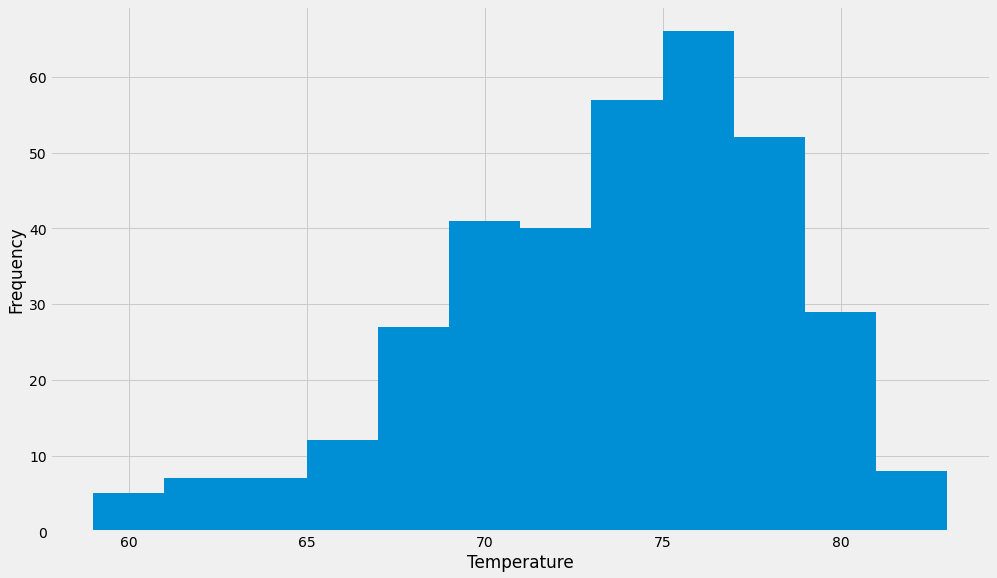

In [24]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data_tobs = session.query(measurement.tobs) \
    .filter(measurement.date >= yearprior) \
    .filter(measurement.station == max_station).all()

tobs_df = pd.DataFrame(data_tobs, columns=['tobs']).dropna()
tobs_df.plot.hist(bins=12, figsize=(15,9), legend=False)
plt.xlabel('Temperature')
plt.show()

# Close session

In [26]:
# Close Session
session.close()